# Training Models

Since, now you don't know what's working under the hood. We start by looking the Linear Regression, the simplest model there is.

There are two different ways to train Linear Regression:

- Using direct "closed-form" equation that directly computes the model's parameters.
- Using iterative method called Gradient Descent (GD) that update parameters to their rights values.

Next, we'll look at the Polynomial Regression, a more complex model. Since, it has more parameters it can prone to overfitting. We'll look how to check for overfitting by learning curves and then few regularization techniques to reduce overfitting.

Finally, we'll look at two common classification tasks: Logistic Regression and Softmax Regression.

## Linear Regression

A linear model makes prediction by simply computing a weighted sum of the input features, plus a constant term called *bias*.
$$
\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n
$$
In this equation:

- $\hat{y}$ is the predicted value
- $n$ is the number of features
- $x_i$ is the $i^{th}$ feature
- $\theta_j$ is the $j^{th}$ model parameter

This can be written more concisely in vector form:
$$
\hat{y} = h_\theta(x) = {\theta.x}
$$

- $\theta$ and ${x}$ are parameter (including bias) and features ($x_o$ is equal to 1) vectors.
- $h_\theta$ is the hypothesis function using parameters ${\theta}$.

> In ML, vectors are often represented as *column vectors*. So, $\hat{y} = {\theta^Tx}$, where $\theta^T$ is transpose of ${\theta}$ makes it a *row vector*.

To train Linear Regression, we need to find the value of $\theta$ that minimizes the root mean squared error (RMSE). It is simpler to minimize mean squared (MSE) than RMSE, and it produces same result (because values that minimizes MSE also minimize it's square root). 
$$
MSE({X}, h_\theta) = \frac1m\sum_{i=1}^m({\theta^Tx^{(i)}} - y^{(i)})
$$

### The Normal Equation

There is a *closed-form solution* in order to minimize cost function and find values of $\theta$, which is called the *Normal Equation*.
$$
\hat{{\theta}} = ({X}^T{X})^{-1}{X}^T{y}
$$
In this equation:

- $\hat{{\theta}}$ is the value of $\theta$ that minimizes the cost function
- ${y}$ is the target vector

It can be computed using `numpy.linalg.inv()` for inverse, `.dot()` for dot product, and `.T` for transpose.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 *X + np.random.randn(100, 1)

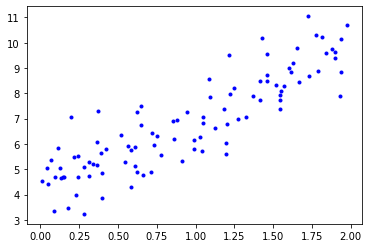

In [3]:
plt.plot(X, y, 'b.')
plt.show()

#### Using Formula

In [4]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

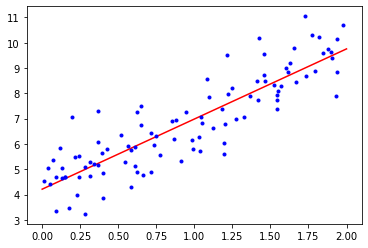

In [6]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.show()

#### Using Sklearn

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

#### Direct SVD

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

#### Pseudo inverse

If ${X}^T{X}$ is not invertible then we can use *pseudo-inverse* of ${X}$. Then equation will be:
$$
\hat{{\theta}} = {X}^+{y}
$$
It can be computed using `numpy.linalg.pinv()` for pseudo-inverse.

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

#### Computational complexity

The Normal Equation computes the inverse of ${X}^T{X}$, which is an $(n+1)\times(n+1)$ matrix. The *complexity* of inverting a matrix is $O(n^3)$. And Sklearn's `LinearRegression` SVD complexity is $O(n^2)$.  

> So, both Normal Equation and SVD gets very slow when the number of features grows large.

So we need a better algorithm which can handle large number of features in efficient memory.

## Gradient Descent

*Gradient Descent* is a generic optimization algorithm capable of finding optimal solution to a wide range of problems. The general idea is to change parameters iteratively in order to minimize the cost function.

Suppose you are lost in mountains in a dense fog. Then best way to get in the bottom is to feel the slope under your feet and take little steps toward descending slope.

In the same way Gradient Descent measures local gradient of the cost function with respect to parameters, and it goes in the direction of descending gradient. Once, gradient is zero, you are at minimum.

You start by filling ${\theta}$ (parameters vector) with some random values, this step is called *random initialization*. Then we update these values until the algorithm *converges* to a minimum.

One important hyperparameter is *learning rate*, which determines how big step would be. If it is too small algorithm may converge after many iteration, on the other hand if it is too large algorithm might not converge at all, this will show opposite effect.

There are two main problems to tackle with while using this algorithm:

- Not all cost function are nice regular bowls, there may be holes, ridges, plateaus, and all sorts of irregular shapes, making it difficult to convergence to minimum. For example, there may be *local minimas*, where algorithm gives gradient zero, rather than on *global minima*. So, choose a smooth *convex* cost function like MSE.
- Second, if features have different scales (like one 0-10, another 100-1000) than the cost function becomes elongated making it longer to converge. If you scale features with Sklearn's `StandardScaler` class, then converges is much faster.

### Batch Gradient Descent

To implement GD, you need to compute gradient of the cost function with regard to each model parameter $\theta_j$. In other words, you need to calculate how much cost function change if you change $\theta_j$ just a little bit. This is called *partial derivative*.

This also calculates slope at that point.
$$
\frac\partial{\partial\theta_j}MSE(\theta) = \frac2m\sum_{i=1}^m(\theta^Tx^{(i)} - y^{(i)}) x_j^{(i)}
$$
Instead of calculating individually, you can calculate derivatives all at once:
$$
\nabla_{\theta}MSE(\theta) = \frac2mX^T(X\theta - y)
$$

> Notice that this formula calculates gradient over whole training set X, that's why it is called *Batch Gradient Descent*. It uses whole batch of training data at every step.

Once you got gradients they points on upward direction, we need to go in opposite direction means subtracting them. What fraction of those gradients we need to subtract decided by learning rate $\eta$.
$$
\theta^{(next\ step)} = \theta - \eta\nabla_{\theta}MSE(\theta)
$$


In [11]:
theta_bgd = []

eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    theta_bgd.append(theta)

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

If you wonder how to set number of iterations, then it's simple keep it big just break the training when gradient becomes tiny, when its norm becomes smaller than a tiny number $\epsilon$ (called the *tolerance*).

*Convergence rate* might be defined by algorithm taking $O(1/\epsilon)$ iterations to converge in smooth convex cost function.

### Stochastic Gradient Descent

SGD picks a random instance and compute gradient with only that, after all instances covered next epoch starts. This makes it faster on large datasets, since only one instance process at a time, it also takes much less memory to process an instance. 

Stochastic means random, and it choose random instance at a time. Due to this nature, SGD is much less regular than Batch GD: instead of gently decreasing, the cost function bounces up and down, and decreases only on average of optimal. Over the time it get to very close of the optimal point, and keeps moving up and down.

When cost function is irregular, it helps algorithm to jump out of local minima, so SGD has better chance of minding global minima.

There is one solution to not converging to minima is gradually decrease learning rate. At start step is big (helps jump out of local minima), then gets smaller and smaller allows algorithm to settle down at global minima. The function that determines the learning rate at each step is called *learning schedule*. As you know learning rate should not reduced too quickly or too slowly.

In [13]:
theta_sgd = []

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_sgd.append(theta)

In [14]:
theta

array([[4.18475289],
       [2.73036719]])

One iteration when all training examples are covered is called an epoch, in SGD total epochs is much less.

Note that you have to choose instances randomly in a way that all instances in training set covered. One way is you can shuffle the training set (making sure inputs and labels are attached), and shuffle again at every epoch.

> If instances are not shuffled and labels are sorted, then algorithm results very bad. Since, first it tries to learn for one class and then changes whole learning and others.

You can use Sklearn's `SGDRegressor(max_iter, tol, penalty, eta0)`, it accepts number of epochs, minimum lost change (condition to break training), regularization, and initial learning rate respectively.

In [15]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor()
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.87477142]), array([3.06982212]))

### Mini-Batch Gradient Descent 

Instead of training on full training, or on only single instance, *Mini-batch GD* takes a random set of instances called *mini-batches*. The main advantage is that you can get performance booster from optimization of matrix operations. For example, Mini-batch GD has to matrix multiply the inputs with weights and dot product make it simple and takes time similar to SGD for calculate only for one instance.

This converge less erratic than SGD, but it can stuck in local minima. Mostly we use mini-batch GD now, as it is fast and with good learning schedule it gives good result.


In [16]:
theta_mgd = []

n_iterations = 50
batch_size = 20

theta = np.random.randn(2, 1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, batch_size):
        t += 1
        xi = X_b_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        gradients = 2 / batch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_mgd.append(theta)

In [17]:
theta

array([[4.23851357],
       [2.7990428 ]])

### Plotting Descent of thetas

In [18]:
theta_bgd = np.array(theta_bgd)
theta_sgd = np.array(theta_sgd)
theta_mgd = np.array(theta_mgd)

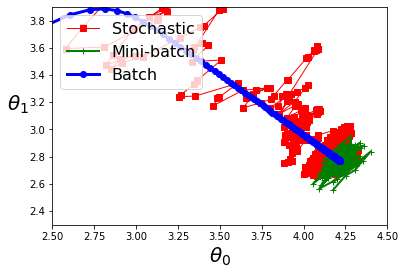

In [19]:
plt.plot(theta_sgd[:, 0], theta_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_mgd[:, 0], theta_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_bgd[:, 0], theta_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Polynomial Regression

In [20]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.93707422])

In [22]:
X_poly[0]

array([0.93707422, 0.87810809])

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.97449026]), array([[0.97553626, 0.50284469]]))

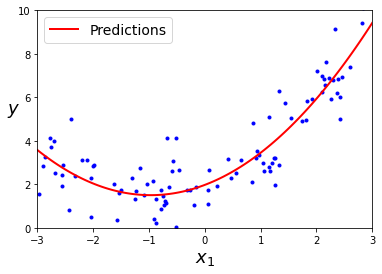

In [24]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning Curves

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [26]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend(loc='upper right')

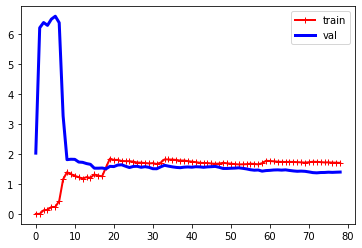

In [27]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

## Regularized Linear Models
### Ridge Regression

In [28]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.77425228]])

#### Using SGD

In [29]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.74180436])

### Lasso Regression

In [30]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.72557684])

### Elastic Net

In [31]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.72881509])

## Early Stopping

In [32]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

In [34]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.inf, warm_start=True, 
                      penalty=None, learning_rate='constant', eta0=5e-4)

In [35]:
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## Logistic Regression

In [36]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [37]:
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int)

In [38]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

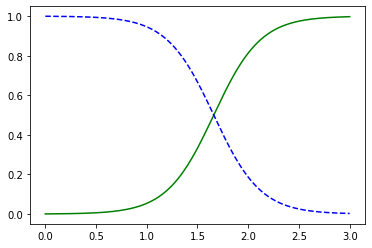

In [40]:
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris virginica')

In [41]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### Softmax Regression

In [42]:
X = iris['data'][:, (2, 3)]
y = iris['target']

In [43]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)
softmax_reg.predict([[5, 2]])

array([2])

In [44]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])